In [25]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import argparse
import numpy as np
import soundfile as sf
from audiodec import AudioDec, assign_model
import matplotlib.pyplot as plt

import torchaudio
import torchaudio.functional as F
from IPython.display import Audio

import pandas as pd

In [27]:
model="libritts_v1"
input="./demo_files/country.wav"
output="./demo_files/asknot_reconstructed.wav"
num_threads=1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_num_threads(num_threads)

# model assignment
sample_rate, encoder_checkpoint, decoder_checkpoint = assign_model(model)

# AudioDec initinalize
print(f"Loading model {model}\n\n")
audiodec = AudioDec(tx_device=device, rx_device=device)
audiodec.load_transmitter(encoder_checkpoint)
audiodec.load_receiver(encoder_checkpoint, decoder_checkpoint)

with torch.no_grad():
    if os.path.exists(input):
        data, fs = sf.read(input, always_2d=True)
        print(data.shape)
    else:
        raise ValueError(f'Input file {input} does not exist!')
    if fs != sample_rate:
        waveform = torch.tensor(data, dtype=torch.float).T
        data = F.resample(waveform, fs, sample_rate, lowpass_filter_width=6).T
        fs = sample_rate


        

    x = np.expand_dims(data.transpose(1, 0), axis=1) # (T, C) -> (C, 1, T)
    x = torch.tensor(x, dtype=torch.float).to(device)
    print("\nEncode/Decode...")
    z = audiodec.tx_encoder.encode(x)
    idx = audiodec.tx_encoder.quantize(z)
    zq = audiodec.rx_encoder.lookup(idx)
    y = audiodec.decoder.decode(zq)[:, :, :x.size(-1)]
    y = y.squeeze(1).transpose(1, 0).cpu().numpy() # T x C


    sf.write(
        output,
        y,
        fs,
        "PCM_16",
    )
    print(f"Output {output}")

print(f"y size: {y.flatten().shape[0]}, x size: {x.flatten().shape[0]}")

print(f"z size: {z.flatten().shape[0]}, idx size: {idx.flatten().shape[0]}, zq size: {zq.flatten().shape[0]}")

print("Input audio")
display(Audio(input))
print("\nOutput audio")
Audio(output)

Loading model libritts_v1


Load tx_encoder: exp/autoencoder/symAD_libritts_24000_hop300/checkpoint-500000steps.pkl
Load rx_encoder: exp/autoencoder/symAD_libritts_24000_hop300/checkpoint-500000steps.pkl
Load decoder: exp/vocoder/AudioDec_v1_symAD_libritts_24000_hop300_clean/checkpoint-500000steps.pkl
(116224, 1)

Encode/Decode...
Output ./demo_files/asknot_reconstructed.wav
y size: 253005, x size: 253005
z size: 54016, idx size: 6752, zq size: 54016
Input audio



Output audio


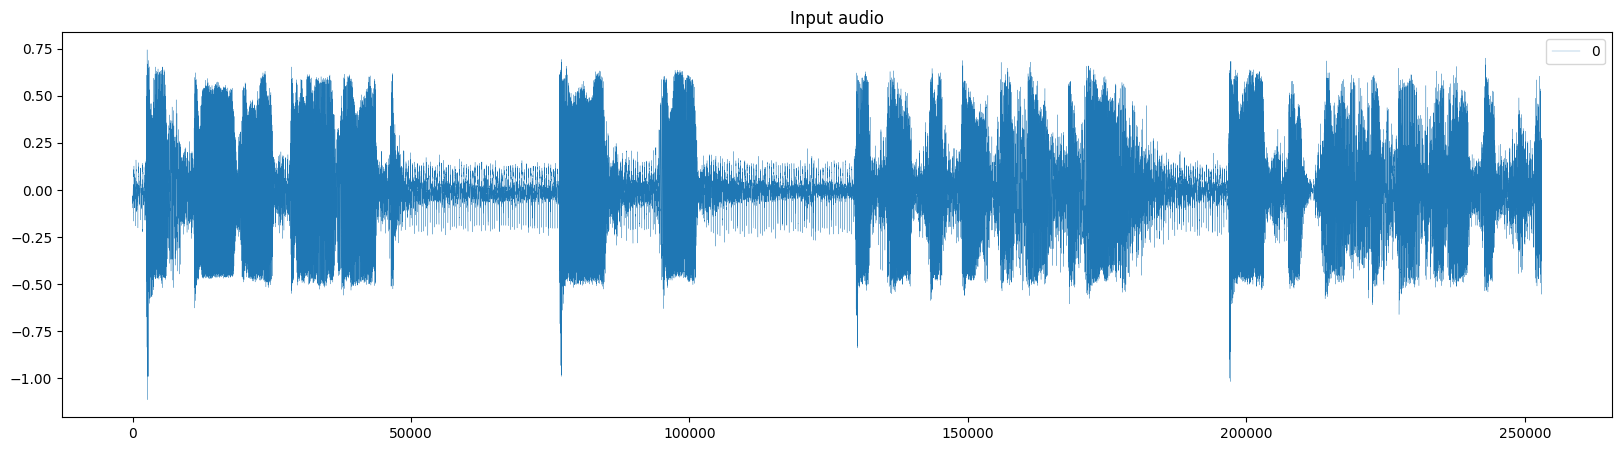

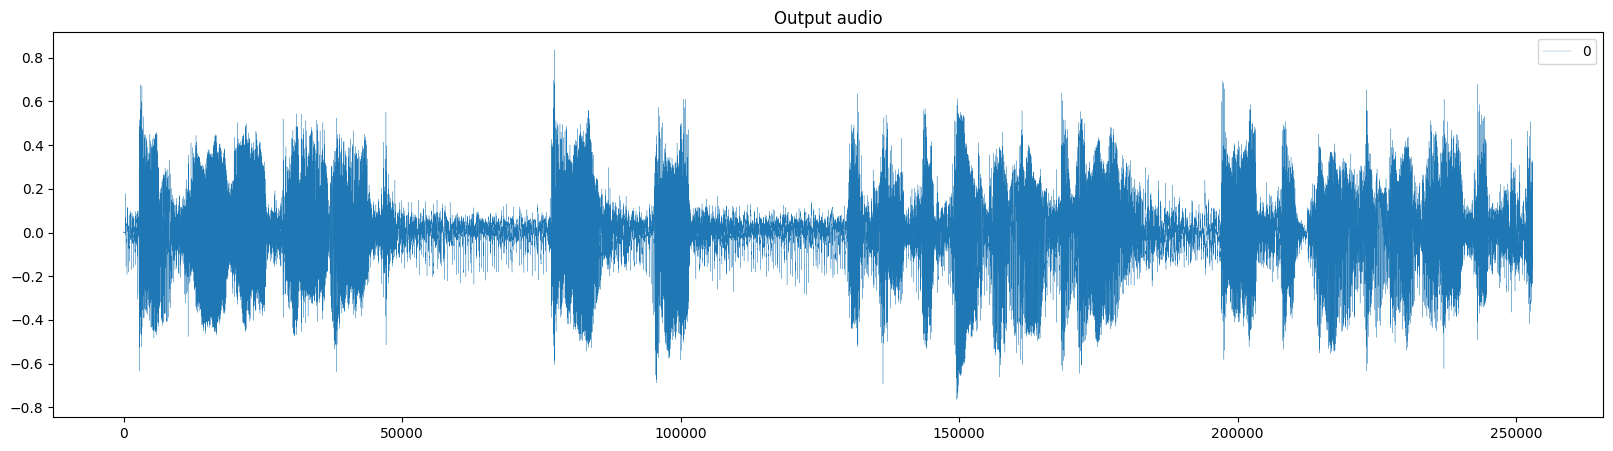

In [32]:
x_df = pd.DataFrame(x.cpu().numpy().squeeze(1).transpose(1, 0))
x_df.plot(lw=0.2, figsize=(20, 5), title="Input audio")
y_df = pd.DataFrame(y)
y_df.plot(lw=0.2, figsize=(20, 5), title="Output audio")
plt.show()

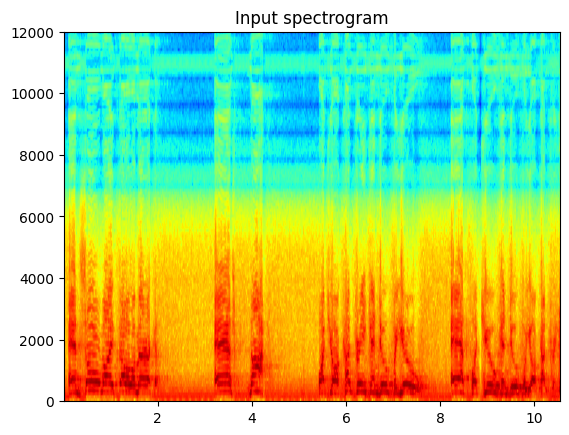

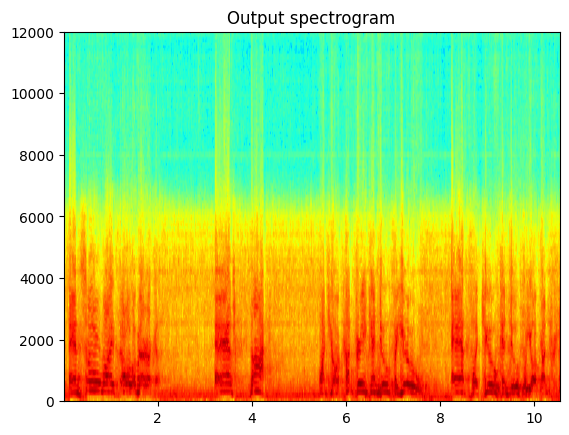

In [90]:
plt.specgram(x.squeeze(1).numpy()[0], Fs=sample_rate, cmap="jet")
plt.title("Input spectrogram")
plt.show()

plt.specgram(y.T[0], Fs=sample_rate, cmap="jet")
plt.title("Output spectrogram")
plt.show()